<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the first dataset

We first need to load the dataset. 

In [129]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [130]:
#@title
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
#@title
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

im = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
batch_Size = 2
dataloader = DataLoader(im, batch_size = batch_Size, shuffle = False, num_workers = 0)
data = iter(dataloader)
images, labels = next(data)

idx_to_class = {j:i for i,j in im.class_to_idx.items()}

Let's import an image with label 0. 

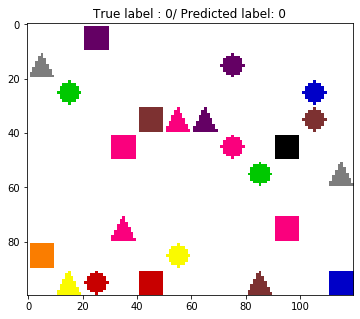

In [132]:
#@title
image0 = images[0]
label0 = labels[0]

im0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 

outputs = net(im0)

_, predicted0 = torch.max(outputs.data, 1)

def denormalize(im): 
  return im*0.5 + 0.5

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  im = denormalize(sample_image)
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[int(true_label)]
  
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]

  plt.title(title_)

display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it doesn't contain any crosses. 

What parts in the input were considered important by the network to make this call ? 

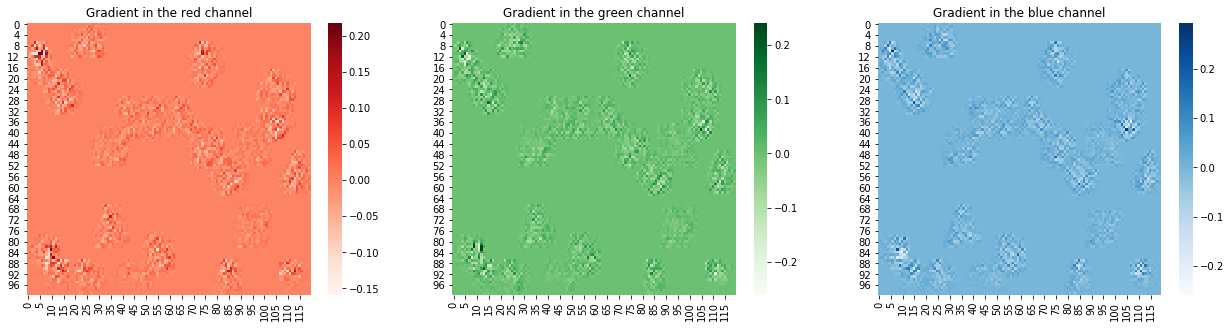

In [133]:
#@title
im0.requires_grad = True # Otherwise we can't compute the gradient 
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(im0, label0)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients0.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients0.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients0.detach().numpy()[2], cmap="Blues", ax = ax3)

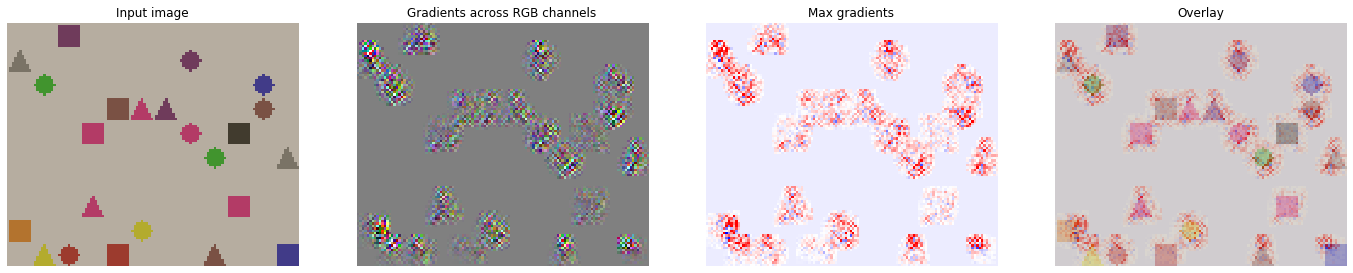

In [134]:
#@title
backprop.visualize(im0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

There is too much noise to extract some valuable information. 

What about an image with label 1 ?

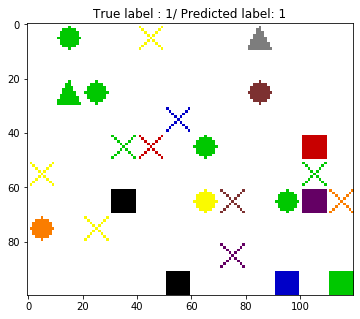

In [135]:
#@title
image1 = images[1]
label1 = labels[1]

im1 = image1.view(-1, 3, 100, 120)
outputs = net(im1)
_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

This image was correctly labeled as a 1, because it contains crosses.

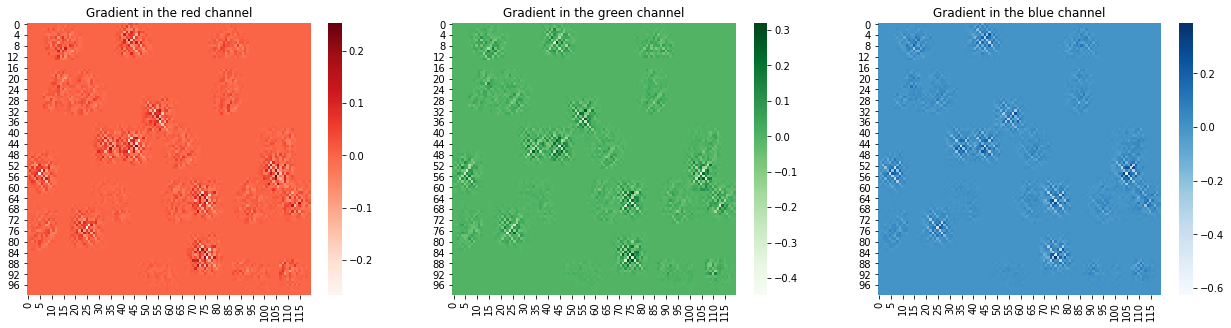

In [136]:
#@title
im1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(im1, label1)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients1.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients1.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients1.detach().numpy()[2], cmap="Blues", ax = ax3)

Though we see the regions with crosses highlighted, the map is not sharp and easy to understand. 

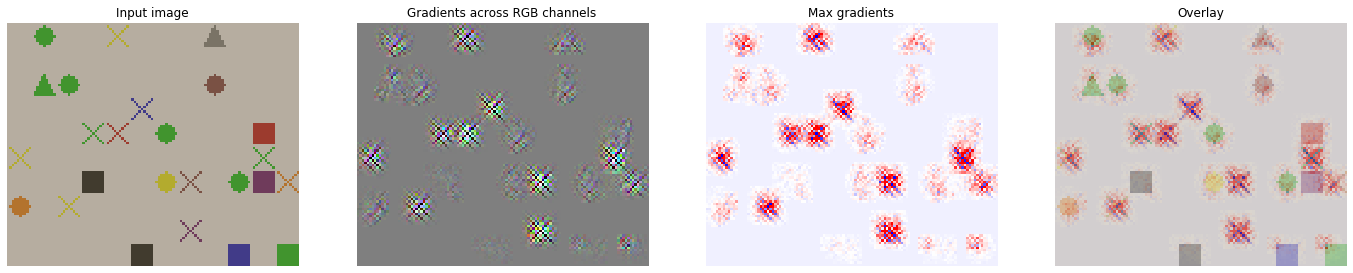

In [137]:
#@title
backprop.visualize(im1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

Red


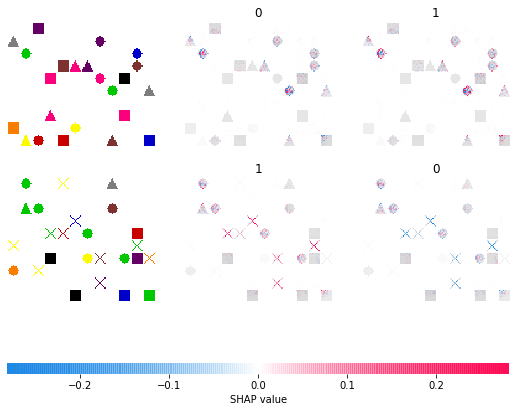

Green


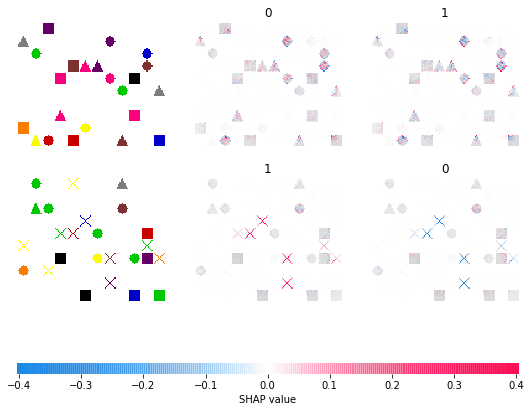

Blue


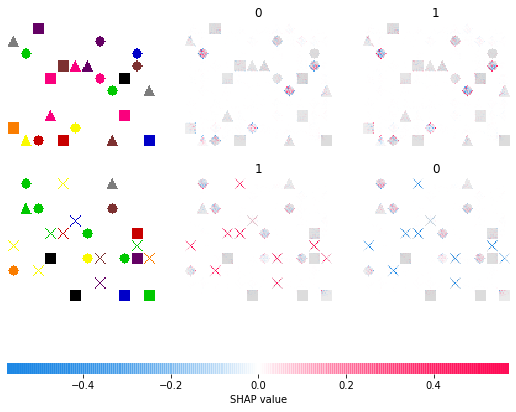

In [138]:
#@title
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = 50, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)
X,Y = next(train_loader)

to_explain = images

e = shap.GradientExplainer(net, X)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


to_explain = np.swapaxes(to_explain,1,2)
to_explain = np.swapaxes(to_explain,2,3)
#to_explain[:,:,:,1] = -0.1*torch.ones(2,100,120)

images_plot = (denormalize(to_explain.numpy()))

shap_red = [shap_values[0][:,:,:,0], shap_values[1][:,:,:,0]]
shap_green = [shap_values[0][:,:,:,1], shap_values[1][:,:,:,1]]
shap_blue = [shap_values[0][:,:,:,2], shap_values[1][:,:,:,2]]

print("Red")
shap.image_plot(shap_red, images_plot, indexes.numpy())
print("Green")
shap.image_plot(shap_green, images_plot, indexes.numpy())
print("Blue")
shap.image_plot(shap_blue, images_plot, indexes.numpy()) 